In [184]:
import genjax
import jax
import jax.numpy as jnp
import matplotlib
import matplotlib.animation as animation
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from genjax import ChoiceMapBuilder as C
from genjax import Pytree, Weight, gen, pretty
from genjax._src.generative_functions.distributions.distribution import Distribution
from genjax.typing import PRNGKey, FloatArray

pretty()
key = jax.random.PRNGKey(0)

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
matplotlib.rcParams["animation.embed_limit"] = 25

Here's a simple image representing a black and white version of the GenJAX logo.

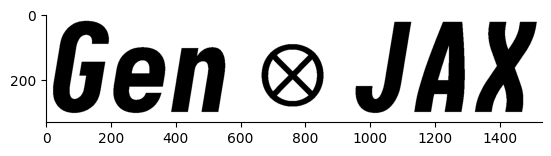

In [308]:
# Load the image
im = mpimg.imread("../../../docs/assets/img/logo.png")

# Convert to mask
im = np.amax(im[:, :, :2], 2) < 0.9
# invert the image
im = np.logical_not(im)

# Convert back to float
im = im.astype(float)
height, width = im.shape
# plot the image
plt.imshow(im, cmap="gray")
plt.show()

We can see this as a uniform distribution on the black part of the image. 
Let's write a GenJAX model that captures this idea.

In [309]:
# Define the model that generated the image
@Pytree.dataclass
class Logo(Distribution):
    image: FloatArray = Pytree.static() 
    threshold: float = Pytree.static(default=1e2)
    
    def log_likelihood(self, x, y, height, width, temperature):
        floor_x, floor_y = jnp.floor(x), jnp.floor(y)
        floor_x, floor_y = jnp.astype(floor_x, jnp.int32), jnp.astype(floor_y, jnp.int32)
        out_of_bounds = (floor_x < 0) | (floor_x >= width) | (floor_y < 0) | (floor_y >= height)
        value = 1./(height * width) - temperature * jax.lax.cond(out_of_bounds,
                            lambda *_: -self.threshold,
                            lambda arg: self.threshold * (self.image[arg[1], arg[0]] == 0),
                            operand=(floor_x, floor_y))
        return value
    
    def random_weighted(self, key: PRNGKey, height, width, temperature):
        key, subkey = jax.random.split(key) 
        x = jax.random.uniform(key, minval=0, maxval=width)
        y = jax.random.uniform(subkey, minval=0, maxval=height)
        logpdf = self.log_likelihood(x, y, height, width, temperature)
        return -logpdf, (x, y)
    
    def estimate_logpdf(self, key: PRNGKey, z, height, width, temperature):
        x, y = z
        return self.log_likelihood(x, y, height, width, temperature)
    
im_jax = jnp.array(im)
logo = Logo(image=im_jax)         

In [310]:
@gen
def model(height, width, temperature):
    z = logo(height, width, temperature) @ "z"
    return z

# Testing
key, subkey = jax.random.split(key)
model.simulate(subkey, (height, width, 0.))

StaticTrace(...)

Now for inference, we will use SMC with a variety of custom proposals. Each intermediate target will be an annealed version of the posterior. We will start from a "high temperature" which we can think of as a more diffuse distribution for which it'll be easier for particles to find a region of decent likelihood, and progressively cool down the process by using smaller temperature parameters in the intermediate targets.

Let's define the initial proposal:

In [311]:
@genjax.gen
def sub_proposal():
    x = genjax.uniform(0.0, float(width)) @ "x"
    y = genjax.uniform(0.0, float(height)) @ "y" 
    return x, y
    
@genjax.gen
def init_proposal():
    z = sub_proposal() @"z"
    return z

# Testing
key, subkey = jax.random.split(key)
jitted_init_proposal = jax.jit(lambda x: init_proposal.simulate(x, ()))
jitted_init_proposal(subkey).get_sample()["z","x"]

<jax.Array(613.8855, dtype=float32)>

From just this basic proposal, we can test SIR.

In [312]:
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, 10000)
trs = jax.vmap(jitted_init_proposal)(keys)

sampled_z = jax.vmap(lambda x: (x.get_choices()["z","x"], x.get_choices()["z","y"]))(trs)
proposal_scores = jax.vmap(lambda x: x.get_score())(trs)

jitted_model = model.importance
key, subkey = jax.random.split(key)
warmup = jitted_model(subkey, C.n(), (height, width, 0.))

In [313]:
# Initial high temperature: the model is uniform
# key is not actually used in jitted_model
key, subkey = jax.random.split(key)
trs, ht_model_scores = jax.vmap(lambda x: jitted_model(subkey, C["z"].set(x), (height, width, 0.)))(sampled_z)
ht_importance_scores = ht_model_scores / proposal_scores
key, subkey = jax.random.split(key)
ht_resampled_indices = jax.random.categorical(subkey, ht_importance_scores, shape=(10000,))
sampled_x, sampled_y = sampled_z
ht_resampled_x = sampled_x[ht_resampled_indices]
ht_resampled_y = sampled_y[ht_resampled_indices]

In [314]:
# Final low temperature: the model is close to uniform on the logo
# key is not actually used in jitted_model
key, subkey = jax.random.split(key)
trs, lt_model_scores = jax.vmap(lambda x: jitted_model(subkey, C["z"].set(x), (height, width, 1.)))(sampled_z)
lt_importance_scores = lt_model_scores / proposal_scores
key, subkey = jax.random.split(key)
lt_resampled_indices = jax.random.categorical(subkey, lt_importance_scores, shape=(10000,))
sampled_x, sampled_y = sampled_z
lt_resampled_x = sampled_x[lt_resampled_indices]
lt_resampled_y = sampled_y[lt_resampled_indices]

Plotting the results

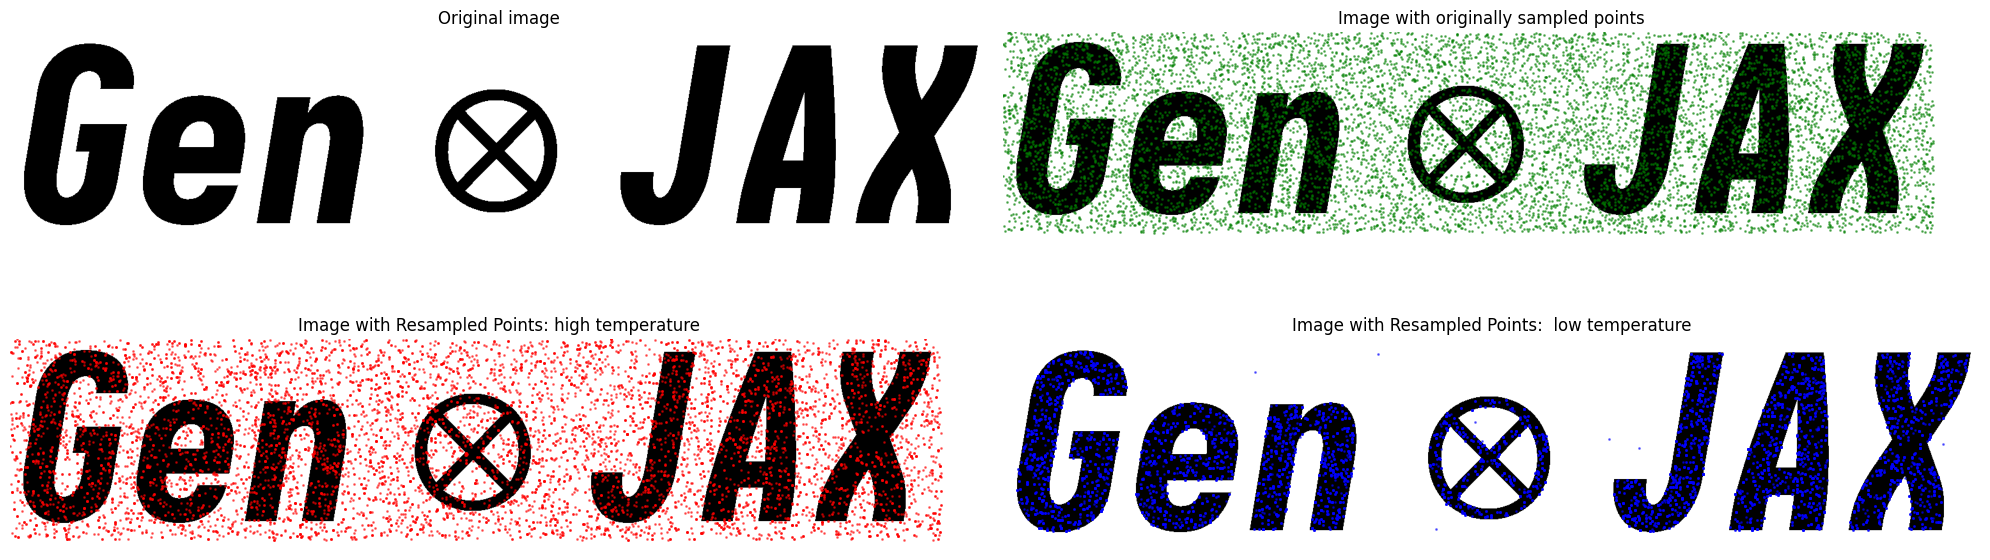

In [315]:
# Create a figure with a 2x2 grid of subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 7))


# Plot 1: Original image
ax1.imshow(im, cmap='gray')
ax1.set_title('Original image')
ax1.axis('off')

# Plot 2: Image with originally sampled points
ax2.imshow(im, cmap='gray')
ax2.scatter(sampled_x, sampled_y, c='green', s=1, alpha=0.5)
ax2.set_title('Image with originally sampled points')
ax2.axis('off')


# Plot 3: Image with resampled Points: high temperature
ax3.imshow(im, cmap='gray')
ax3.scatter(ht_resampled_x, ht_resampled_y, c='red', s=1, alpha=0.5)
ax3.set_title('Image with Resampled Points: high temperature')
ax3.axis('off')


# Plot 4: Image with resampled Points: low temperature
ax4.imshow(im, cmap='gray')
ax4.scatter(lt_resampled_x, lt_resampled_y, c='blue', s=1, alpha=0.5)
ax4.set_title('Image with Resampled Points:  low temperature')
ax4.axis('off')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Let's try a few intermediate stages between the high and low temperatures.

In [316]:
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, 1000)
trs = jax.vmap(jitted_init_proposal)(keys)
sampled_z = jax.vmap(lambda x: (x.get_choices()["z","x"], x.get_choices()["z","y"]))(trs)
proposal_scores = jax.vmap(lambda x: x.get_score())(trs)

all_sampled_x = [] 
all_sampled_y = []
number_steps = 10

for tmp in jnp.arange(0., 1.+1./number_steps, 1./number_steps):
    key, subkey = jax.random.split(key)
    trs, model_scores = jax.vmap(lambda x: jitted_model(subkey, C["z"].set(x), (height, width, tmp)))(sampled_z)
    importance_scores = model_scores / proposal_scores
    key, subkey = jax.random.split(key)
    resampled_indices = jax.random.categorical(subkey, importance_scores, shape=(1000,))
    sampled_x, sampled_y = sampled_z
    resampled_x = sampled_x[resampled_indices]
    resampled_y = sampled_y[resampled_indices]
    all_sampled_x.append(resampled_x)
    all_sampled_y.append(resampled_y)

Which we can visualize:

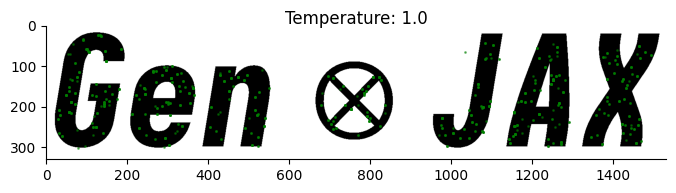

In [317]:
fig, ax = plt.subplots(figsize=(8, 2))
images = []

ax.imshow(im, cmap='gray', extent=[0, width, height, 0])

for i in range(0,number_steps+1):
    scatter = ax.scatter(all_sampled_x[i], all_sampled_y[i], c='green', s=1, alpha=0.5)
    title = ax.text(0.5, 1.05, f'Temperature: {i/number_steps:.1f}', 
                    ha='center', va='center', transform=ax.transAxes, fontsize=12)
    images.append([scatter, title])
    
ani = animation.ArtistAnimation(fig, images, interval=200, blit=True, repeat_delay=1000)

# Save the animation as a GIF
ani.save("initial_IS_animation.gif", writer="pillow")

# Display the animation in the notebook
from IPython.display import HTML

HTML(ani.to_jshtml())    

Let's now evolve the particles over time using SMC.

In [349]:
number_steps = 10
num_particles = 1000
# v1: random wiggling proposal
@genjax.gen
def proposal1(x, y):
    x = genjax.normal(x, 0.5) @ "x"
    y = genjax.normal(y, 0.5) @ "y"
    return x, y


# v2: rotating proposal distribution
@genjax.gen
def proposal2(x, y):
    theta = 0.3
    x, y = x * cos(theta) - y * sin(theta), x * sin(theta) + y * cos(theta)
    x = genjax.normal(x, 0.5) @ "x"
    y = genjax.normal(y, 0.5) @ "y"
    return x, y


# v3: spiraling inwards proposal distribution
@genjax.gen
def proposal3(x, y):
    theta = 0.3
    inward_coeff = (x + y) / 2
    x, y = (
        x * cos(theta) - y * sin(theta),
        x * sin(theta) + y * cos(theta),
    ) * inward_coeff
    x = genjax.normal(x, 0.5) @ "x"
    y = genjax.normal(y, 0.5) @ "y"
    return x, y

@gen
def step_model(chm, i):
    x = chm["z","x"]
    y =  chm["z","y"]
    if i==1:
        new_z = proposal1(x,y) @"z"
    elif i==2:
        new_z = proposal2(x,y) @"z"
    elif i==3: 
        new_z = proposal3(x,y) @"z"
    return new_z

@genjax.gen
def proposal1(chm):
    x = chm["z","x"]
    y =  chm["z","y"]
    x = genjax.normal(x, 0.5) @ "x"
    y = genjax.normal(y, 0.5) @ "y"
    return x, y

all_sampled_x = [] 
all_sampled_y = []

# samples and scores from proposal
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num_particles)
trs = jax.vmap(jitted_init_proposal)(keys)
sampled_z = jax.vmap(lambda x: (x.get_choices()["z","x"], x.get_choices()["z","y"]))(trs)
proposal_scores = jax.vmap(lambda x: x.get_score())(trs)

# scores from model at high temperature
key, subkey = jax.random.split(key)
trs, model_scores = jax.vmap(lambda x: jitted_model(subkey, C["z"].set(x), (height, width, 0.)))(sampled_z)

# importance scores and resampling
importance_scores = model_scores / proposal_scores
key, subkey = jax.random.split(key)
resampled_indices = jax.random.categorical(subkey, importance_scores, shape=(1000,))
sampled_x, sampled_y = sampled_z
resampled_x = sampled_x[resampled_indices]
resampled_y = sampled_y[resampled_indices]
chms = jax.vmap(lambda p: C["z","x"].set(p))(resampled_x) ^ jax.vmap(lambda p: C["z","y"].set(p))(resampled_y)

# store results for later visualization
all_sampled_x.append(resampled_x)
all_sampled_y.append(resampled_y)
 
# jitting the step_proposal and warmup
jitted = jax.jit(proposal1.vmap().simulate)
key, subkey = jax.random.split(key)
warmup_chm = C["z","x"].set(1.) ^ C["z","y"].set(1.)
jitted(subkey, jnp.array(warmup_chm,))

# keys = jax.random.split(subkey, num_particles)
# trs = jax.vmap(jitted, in_axes=(0, 0))(keys, chms)
# sampled_z = jax.vmap(lambda x: (x.get_choices()["z","x"], x.get_choices()["z","y"]))(trs)
# proposal_scores = jax.vmap(lambda x: x.get_score())(trs)
    
# for tmp in jnp.arange(0., 1.+1./number_steps, 1./number_steps):
#     # samples and scores from proposal kernels using the chm from previous step
#     key, subkey = jax.random.split(key)
#     keys = jax.random.split(subkey, num_particles)
#     trs = jax.vmap(jitted, in_axes=(0, 0))(keys, chms)
#     sampled_z = jax.vmap(lambda x: (x.get_choices()["z","x"], x.get_choices()["z","y"]))(trs)
#     proposal_scores = jax.vmap(lambda x: x.get_score())(trs)

#     # scores from model at intermediate temperature
#     key, subkey = jax.random.split(key)
#     trs, model_scores = jax.vmap(lambda x: jitted_model(subkey, C["z"].set(x), (height, width, 0.)))(sampled_z)

#     # importance scores and resampling
#     importance_scores = model_scores / proposal_scores
#     key, subkey = jax.random.split(key)
#     resampled_indices = jax.random.categorical(subkey, importance_scores, shape=(1000,))
#     sampled_x, sampled_y = sampled_z
#     resampled_x = sampled_x[resampled_indices]
#     resampled_y = sampled_y[resampled_indices]
#     chm = jax.vmap(lambda p: C["z","x"].set(p))(resampled_x) ^ jax.vmap(lambda p: C["z","y"].set(p))(resampled_y)
    
#     # store results for later visualization
#     all_sampled_x.append(resampled_x)
#     all_sampled_y.append(resampled_y)

ValueError: setting an array element with a sequence.

Visualizing what we got!

/var/folders/9j/hglb3g2s4z16d49xygdv5_m40000gp/T/ipykernel_53600/2566984868.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = ax.scatter(all_sampled_x[i], all_sampled_y[i], c=color, s=1, alpha=0.5)


IndexError: list index out of range

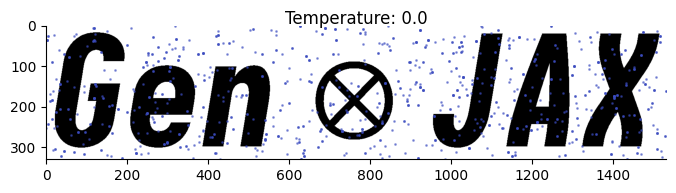

In [351]:
fig, ax = plt.subplots(figsize=(8, 2))
images = []

ax.imshow(im, cmap='gray', extent=[0, width, height, 0])

for i in range(0,number_steps+1):
    color = plt.cm.coolwarm(i / number_steps)
    scatter = ax.scatter(all_sampled_x[i], all_sampled_y[i], c=color, s=1, alpha=0.5)
    title = ax.text(0.5, 1.05, f'Temperature: {i/number_steps:.1f}', 
                    ha='center', va='center', transform=ax.transAxes, fontsize=12)
    images.append([scatter, title])
    
ani = animation.ArtistAnimation(fig, images, interval=200, blit=True, repeat_delay=1000)

# Save the animation as a GIF
ani.save("SMC_animation.gif", writer="pillow")

# Display the animation in the notebook
from IPython.display import HTML

HTML(ani.to_jshtml())    

Now we can add a circular mask for the initial proposal:

In [ ]:
TODO 

In [ ]:
 # Desired interactions:
 # - mask disk centred around mouse cursor. truncated to borders of the image
 # - mouse scroll: change radius of mask between 10 and 100 pixel
 # - left click: higher temperature (max exp^0)
 # - right click: lower temperature (min exp^{-1})
 # - SMC running while all of this is happening.
 # - may want yet another way to change the number of particles: with 1000 it's hard to see the logo but with 10k it's obvious.
 # - the rejuv dynamics could be guided by the mouse cursor moving. so that we can have particle move and bump more against the letters which a human can infer.

In [299]:
# TODO: because of the "z" vs "x", "y" distinction in the trace, we'd need some kind of trace translator to tell the algorithm to use the [“z”, (“x”, “y”)] sample as a "z" for the model.
target = genjax.Target(model, (height, width, 0.), C.n())

In [72]:
# Method 2: Define the model that generated the image
# It will be a more noisy version of the uniform distribution we just described.
@genjax.gen
def pixel_model(temperature):
    x = genjax.uniform(0.0, 1.0) @ "x"
    obs = genjax.normal(x, 0.01 * exp(-temperature)) @"obs"
    return obs

model = pixel_model.vmap(in_axes=(0,)).vmap(in_axes=(0,))

chm = C[jnp.arange(height), jnp.indices((height,width))[1], "obs"].set(im)

In [17]:
# Define the prior model
@genjax.gen
def prior_model(height, width):
    # Particles are uniformly randomly initialized within the image frame
    x = genjax.uniform(0.0, height) @ "x"
    y = genjax.uniform(0.0, width) @ "y"
    
    obs_x = genjax.normal(x, 1.0) @ "obs_x"
    obs_y = genjax.normal(y, 1.0) @ "obs_y"
    return x, y


jax_im = jnp.array(im.astype(float))
n_samples = 5000
batched_prior_model = prior_model.repeat(n=n_samples)

key, subkey = jax.random.split(key)
tr = batched_prior_model.simulate(subkey, (float(height), float(width)))
xs_init, ys_init = tr.get_choices()[..., "x"], tr.get_choices()[..., "y"]
zs_init = np.stack([xs_init, ys_init], axis=1)